In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained Swin Transformer model
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=3).to(device)

# Load the pre-trained model's state dictionary
pretrained_model_path = "swin_tiny_patch4_window7_224.pth"
pretrained_state_dict = torch.load(pretrained_model_path, map_location=torch.device('cuda'))['model']

# Change the output layer's weights and biases to match your model's output layer size
pretrained_state_dict['head.weight'] = pretrained_state_dict['head.weight'][:3, :]
pretrained_state_dict['head.bias'] = pretrained_state_dict['head.bias'][:3]

# Load the modified state dictionary into your model
model.load_state_dict(pretrained_state_dict)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [3]:
import torch
from timm.models import create_model

num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in SwinTransformer model: {num_params}")


Number of parameters in SwinTransformer model: 27521661


In [4]:
#print(model)

In [5]:
# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:


data_dir = "datas2"

train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and validation
num_epochs = 16
train_acc_history = []
val_acc_history = []
val_auc_history = []
val_f1_history = []
val_r_history = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)


    
        # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_outputs_list = []
    val_labels_list = []
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_outputs_list.append(outputs.cpu().numpy())
            val_labels_list.append(labels.cpu().numpy())

        val_acc = val_correct / val_total
        val_acc_history.append(val_acc)

        val_outputs = np.concatenate(val_outputs_list, axis=0)
        val_labels = np.concatenate(val_labels_list, axis=0)

        val_fpr, val_tpr, _ = roc_curve(val_labels, val_outputs[:, 1], pos_label=1)
        val_auc = auc(val_fpr, val_tpr)
        val_auc_history.append(val_auc)

        val_f1 = f1_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
        val_f1_history.append(val_f1)

        val_r = recall_score(val_labels, np.argmax(val_outputs, axis=1),average='weighted')
        val_r_history.append(val_r)

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Val F1: {val_f1:.4f}, Val Recall: {val_r:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/16, Train Acc: 0.7384, Val Acc: 0.8306, Val AUC: 0.9531, Val F1: 0.8335, Val Recall: 0.8306, Val Loss: 0.4163
Epoch 2/16, Train Acc: 0.8729, Val Acc: 0.8556, Val AUC: 0.9658, Val F1: 0.8526, Val Recall: 0.8556, Val Loss: 0.3442
Epoch 3/16, Train Acc: 0.9039, Val Acc: 0.9139, Val AUC: 0.9828, Val F1: 0.9147, Val Recall: 0.9139, Val Loss: 0.2129
Epoch 4/16, Train Acc: 0.9468, Val Acc: 0.9556, Val AUC: 0.9909, Val F1: 0.9554, Val Recall: 0.9556, Val Loss: 0.1449
Epoch 5/16, Train Acc: 0.9483, Val Acc: 0.9583, Val AUC: 0.9946, Val F1: 0.9585, Val Recall: 0.9583, Val Loss: 0.1100
Epoch 6/16, Train Acc: 0.9623, Val Acc: 0.9250, Val AUC: 0.9771, Val F1: 0.9249, Val Recall: 0.9250, Val Loss: 0.2343
Epoch 7/16, Train Acc: 0.9586, Val Acc: 0.9472, Val AUC: 0.9960, Val F1: 0.9477, Val Recall: 0.9472, Val Loss: 0.1547
Epoch 8/16, Train Acc: 0.9719, Val Acc: 0.9389, Val AUC: 0.9926, Val F1: 0.9391, Val Recall: 0.9389, Val Loss: 0.1432
Epoch 9/16, Train Acc: 0.9727, Val Acc: 0.9667, Val AUC:

In [8]:
torch.save(model.state_dict(), "swin_model0329.pth")

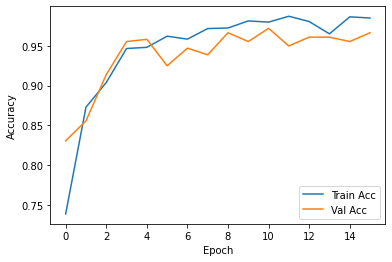

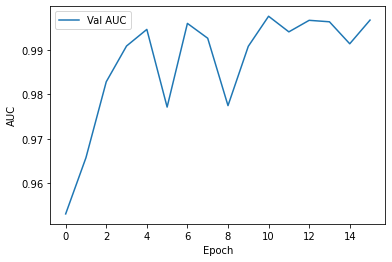

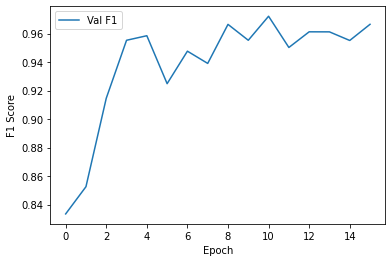

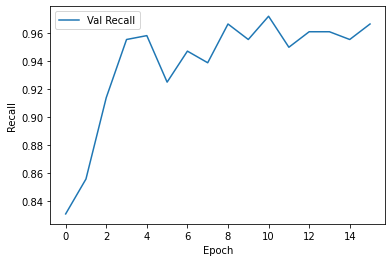

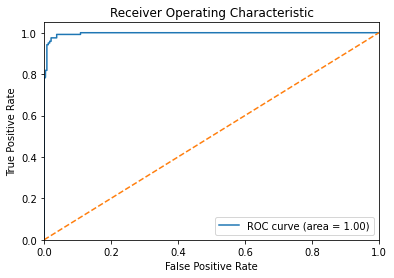

In [9]:
plt.figure()
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_auc_history, label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_f1_history, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_r_history, label="Val Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()
plt.figure()
plt.plot(val_fpr, val_tpr, label=f'ROC curve (area = {val_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

In [11]:
# Create a data loader for the images
import torch.nn.functional as F
data_dir = "datas2/val"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_data = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(image_data, batch_size=1, shuffle=False)

# Predict and evaluate
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)  # 使用softmax函数进行概率化处理
        _, predicted = torch.max(outputs, 1)
        y_true.append(labels.item())
        y_pred.append(predicted.item())
        y_scores.append(probabilities.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.concatenate(y_scores, axis=0)

acc = accuracy_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_scores, multi_class='ovo')
f1 = f1_score(y_true, y_pred,average='weighted')
recall = recall_score(y_true, y_pred,average='weighted')

print(f"Accuracy: {acc:.4f}, AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

Accuracy: 0.9667, AUC: 0.9974, F1 Score: 0.9666, Recall: 0.9667


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       109
           1       0.97      0.93      0.95       121
           2       0.94      0.98      0.96       130

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



In [12]:
# Create a data loader for the images
import torch.nn.functional as F
data_dir = "datas2/train"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_data = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(image_data, batch_size=1, shuffle=False)

# Predict and evaluate
y_true1 = []
y_pred1 = []
y_scores1 = []

with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)  # 使用softmax函数进行概率化处理
        _, predicted = torch.max(outputs, 1)
        y_true1.append(labels.item())
        y_pred1.append(predicted.item())
        y_scores1.append(probabilities.cpu().numpy())

y_true1 = np.array(y_true1)
y_pred1 = np.array(y_pred1)
y_scores1 = np.concatenate(y_scores1, axis=0)

acc1 = accuracy_score(y_true1, y_pred1)
auc_score1 = roc_auc_score(y_true1, y_scores1, multi_class='ovo')
f11 = f1_score(y_true1, y_pred1,average='weighted')
recall1 = recall_score(y_true1, y_pred1,average='weighted')

print(f"Accuracy: {acc1:.4f}, AUC: {auc_score1:.4f}, F1 Score: {f11:.4f}, Recall: {recall1:.4f}")

Accuracy: 0.9904, AUC: 0.9999, F1 Score: 0.9904, Recall: 0.9904


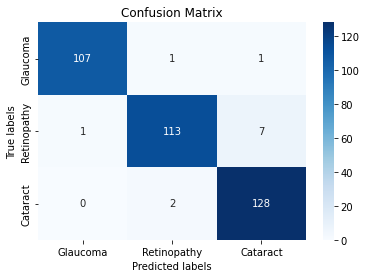

In [13]:
import seaborn as sns

# Define class labels
labels = ['Glaucoma','Retinopathy','Cataract']  # 用您的实际类别标签替换...

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure()
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
